In [1]:
import warnings
warnings.filterwarnings('ignore')

# Group Project - Linear Models

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import duckdb

sns.set(style="whitegrid")

## Data Loading

In [4]:
con = duckdb.connect(database='ps6.duckdb', read_only=False)

In [5]:
# Loading dataset
# connect to database

# read the result of an arbitrary SQL query to a Pandas DataFrame
all_listings = con.execute("SELECT * from all_listings").df()

In [6]:
latest_listings = con.execute("SELECT * from latest_listings").df()

In [7]:
neighborhoods = con.execute("SELECT * from neighborhoods").df()

In [8]:
reviews = con.execute("SELECT * from reviews").df()

In [9]:
calendar = con.execute("SELECT * from calendar").df()

In [10]:
crimes = con.execute("SELECT * from calendar").df()

In [12]:
neighborhood_crimes = con.execute("SELECT * from neighborhood_crimes").df()

In [13]:
full_latest_listings = con.execute("SELECT * from full_latest_listings").df()

In [171]:
all_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   neighbourhood_group  0 non-null      object
 1   neighbourhood        39 non-null     object
 2   type_outer           39 non-null     object
 3   feature_type         39 non-null     object
 4   geometry_type        39 non-null     object
 5   coordinates          39 non-null     object
dtypes: object(6)
memory usage: 2.0+ KB


In [5]:
latest_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
neighborhoods.info()

In [ ]:
reviews.info()

In [ ]:
calendar.info()

In [ ]:
crimes.info()

In [ ]:
neighborhood_crimes.info()

In [14]:
full_latest_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10560 entries, 0 to 10559
Data columns (total 85 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            10560 non-null  int64         
 1   listing_url                                   10560 non-null  object        
 2   scrape_id                                     10560 non-null  int64         
 3   last_scraped                                  10560 non-null  datetime64[ns]
 4   name                                          10559 non-null  object        
 5   description                                   10416 non-null  object        
 6   neighborhood_overview                         6559 non-null   object        
 7   picture_url                                   10560 non-null  object        
 8   host_id                                       10560 non-null  int3

Variables to include in first linear regression:
* accomodates (listings)
* room_type (listings)
* review_score_value (listings)
* review_score_location (listings)
* review_score_communication (listings)
* review_score_cleanliness (listings)
* violent_crime_per_neighborhood (???)
* host_identity_verified (listings)
* host_acceptance_rate (listings)
* host_listings_count MAYBE (listings)

In [22]:
## create jumbo dataframe of all of these
combined = full_latest_listings[full_latest_listings[['price',
                                 'accommodates',
                                 'room_type',
                                 'review_scores_value',
                                 'review_scores_location',
                                 'review_scores_communication',
                                 'review_scores_cleanliness',
                                 'host_identity_verified',
                                 'host_acceptance_rate',
                                 'host_listings_count']].notnull().all(1)]
filtered_df = df[df[['name', 'country', 'region']].notnull().all(1)]

In [31]:
combined_non_nan = full_latest_listings[full_latest_listings[['price',
                                 'accommodates',
                                 'room_type',
                                 'review_scores_value',
                                 'review_scores_location',
                                 'review_scores_communication',
                                 'review_scores_cleanliness',
                                 'host_identity_verified',
                                 'host_acceptance_rate',
                                 'host_listings_count']].notnull().all(1)]
combined_non_nan = combined_non_nan[['price',
                                 'accommodates',
                                 'room_type',
                                 'review_scores_value',
                                 'review_scores_location',
                                 'review_scores_communication',
                                 'review_scores_cleanliness',
                                 'host_identity_verified',
                                 'host_acceptance_rate',
                                 'host_listings_count']].copy()

In [32]:
combined_non_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7520 entries, 0 to 10549
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price                        7520 non-null   float64
 1   accommodates                 7520 non-null   int32  
 2   room_type                    7520 non-null   object 
 3   review_scores_value          7520 non-null   float64
 4   review_scores_location       7520 non-null   float64
 5   review_scores_communication  7520 non-null   float64
 6   review_scores_cleanliness    7520 non-null   float64
 7   host_identity_verified       7520 non-null   object 
 8   host_acceptance_rate         7520 non-null   object 
 9   host_listings_count          7520 non-null   float64
dtypes: float64(6), int32(1), object(3)
memory usage: 616.9+ KB


In [46]:
# TODO: Add columns from other databases
# violent_crime_per_neighborhood

In [45]:
# TODO: Encode categorical variables into one-hot-encodings

In [19]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [ ]:
# get rid of NaNs
combined = combined()

In [34]:
correlations(combined_non_nan, "price", ['accommodates',
                                 'review_scores_value',
                                 'review_scores_location',
                                 'review_scores_communication',
                                 'review_scores_cleanliness',
                                 'host_listings_count'])

,feature,r,rho
0,accommodates,0.335127,0.603468
1,review_scores_value,-0.011439,-0.028919
2,review_scores_location,0.057894,0.199798
3,review_scores_communication,0.001850,0.015064
4,review_scores_cleanliness,0.027069,0.108262
5,host_listings_count,0.021686,0.043978


In [36]:
import models

In [37]:
model = "price ~ accommodates + review_scores_value + review_scores_location +review_scores_communication + review_scores_cleanliness + host_listings_count"
result1 = models.bootstrap_linear_regression(model, data=combined_non_nan)
models.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-137.41,-191.32,-79.58
accommodates,$\beta_{1}$,36.32,32.86,40.43
review_scores_value,$\beta_{2}$,-50.40,-81.94,-22.54
review_scores_location,$\beta_{3}$,62.41,47.43,78.68
review_scores_communication,$\beta_{4}$,0.44,-13.88,14.02
review_scores_cleanliness,$\beta_{5}$,21.89,-0.69,42.41
host_listings_count,$\beta_{6}$,0.02,0.01,0.02
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,


In [43]:
def plot_residuals(result, variables):
    figure = plt.figure(figsize=(20,6))

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(combined_non_nan[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

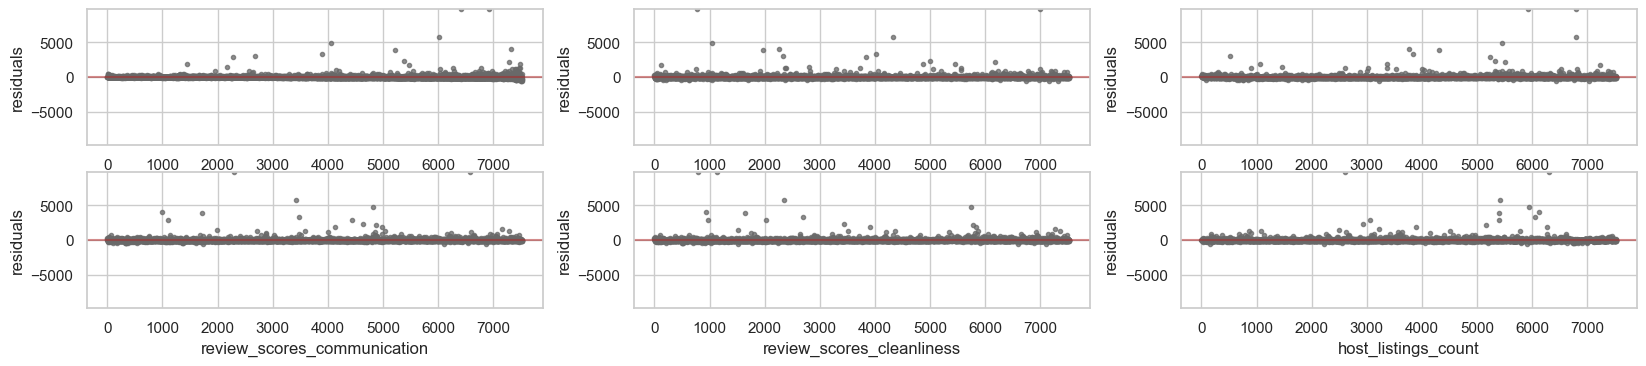

In [44]:
residuals1 = plot_residuals(result1, ['accommodates',
                                 'review_scores_value',
                                 'review_scores_location',
                                 'review_scores_communication',
                                 'review_scores_cleanliness',
                                 'host_listings_count'])